In [1]:
# Importing dependencies
import sys
import numpy as np
# np.random.seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [2]:
# Loading the dataset
#url = 'https://raw.githubusercontent.com/ninja3697/dataset/master/CSV.csv'
data_path = 'new2.csv'
df = pd.read_csv(data_path)
df.tail()

,label,open,high,low,close,high_ewma,low_ewma,close_ewma,open_ewma,Volatility,close_price,high_price,low_price,open_price,label2
1984,0.003521,-0.007166,-0.002919,-0.020170,-0.020170,0.004676,-0.008425,-0.003957,0.000952,0.011377,0.861505,0.876673,0.861505,0.872939,0.864539
1985,0.001619,0.005146,0.007042,-0.002709,0.003521,0.005106,-0.007386,-0.002597,0.001715,0.007369,0.864539,0.867572,0.859172,0.865939,0.865939
1986,-0.005659,0.001350,0.004049,-0.002159,0.001619,0.004914,-0.006435,-0.001831,0.001648,0.007372,0.865939,0.868039,0.862672,0.865705,0.861039
1987,0.018428,-0.000539,0.006198,-0.008892,-0.005659,0.005148,-0.006882,-0.002527,0.001251,0.007344,0.861039,0.871306,0.858238,0.865472,0.876906
1988,0.012773,0.002981,0.022493,0.002710,0.018428,0.008301,-0.005138,0.001283,0.001565,0.009609,0.876906,0.880406,0.863372,0.863605,0.888107


In [3]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [4]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]+1):
        X_train.append(train[i-timesteps:i, 0:4])
        Y_train.append(train[i-1][4])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]+1):
        X_val.append(val[i-timesteps:i,0:4])
        Y_val.append(val[i-1][4])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    print(X_train.shape)
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(4,input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],return_sequences = True))
        # model.add(Dropout(0.2))
    model.add(LSTM(hl[-1]))
    # model.add(Dense(20))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(learning_rate = lr), loss = 'mean_squared_error')
    #print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    # model.reset_states()
    return model, history.history['loss'], history.history['val_loss']


In [5]:
# Evaluating the model
def evaluate_model(model,test,timesteps, sc):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]+1):
        X_test.append(test[i-timesteps:i, 0:4])
        Y_test.append(test[i-1][4])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    print(Y_hat.shape)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    df2 = pd.DataFrame({'Actual': Y_test.flatten(), 'Predicted': Y_hat.flatten()})
    df2['actual_return'] = df2['Actual'].pct_change()
    # column predicted_return is (predicted - actual.shift(1))/actual.shift(1)
    df2['predicted_return'] = df2['Predicted'].pct_change()
    # column signal is 1 if predicted_return > 0 and actual_return > 0 or predicted_return < 0 and actual_return < 0
    df2['signal'] = np.where((df2['predicted_return'] > 0) & (df2['actual_return'] > 0) | (df2['predicted_return'] < 0) & (df2['actual_return'] < 0), 1, 0)
    # accuracy is the mean of the signal column
    accuracy = df2['signal'].mean()
    # construct a strategy, if predicted_return > 0, then I plus (actual.shift(-1) - actual), otherwise I minus (actual.shift(-1) - actual)
    df2['strategy'] = np.where(df2['predicted_return'] > 0, (df2['Actual'].shift(-1) - df2['Actual']), -(df2['Actual'].shift(-1) - df2['Actual']))
    # cumulative_strategy is the cumsum of column strategy
    cumulative_strategy = df2['strategy'].sum()
    return mse, rmse, r, Y_test, Y_hat, accuracy, cumulative_strategy
  

In [6]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [7]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

In [8]:
# Extracting the series, only drop the label column
series = df[['open_price', 'high_price', 'low_price', 'close_price', 'label2']]
# series = df[['open', 'high', 'low', 'close', 'label']]
print(series.shape)
print(series.tail())

(1989, 5)
      open_price  high_price  low_price  close_price    label2
1984    0.872939    0.876673   0.861505     0.861505  0.864539
1985    0.865939    0.867572   0.859172     0.864539  0.865939
1986    0.865705    0.868039   0.862672     0.865939  0.861039
1987    0.865472    0.871306   0.858238     0.861039  0.876906
1988    0.863605    0.880406   0.863372     0.876906  0.888107


In [9]:
train_data = series[:int(0.7*len(series))]
val_data = series[int(0.7*len(series)):int(0.85*len(series))]
test_data = series[int(0.85*len(series)):int(1*len(series))]

In [10]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
# train = train_data.values
# val = val_data.values
# test = test_data.values
all_data = sc.transform(series)
print(train.shape,val.shape,test.shape)

(1392, 5) (298, 5) (299, 5)


In [11]:
timesteps = 40
hl = [40, 35]
lr = 0.0005
batch_size = 64
num_epochs = 150

(1353, 40, 4)


/Users/ldvyyc/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


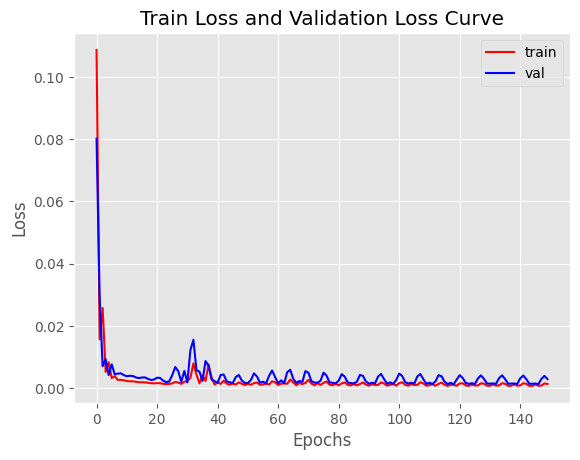

In [12]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

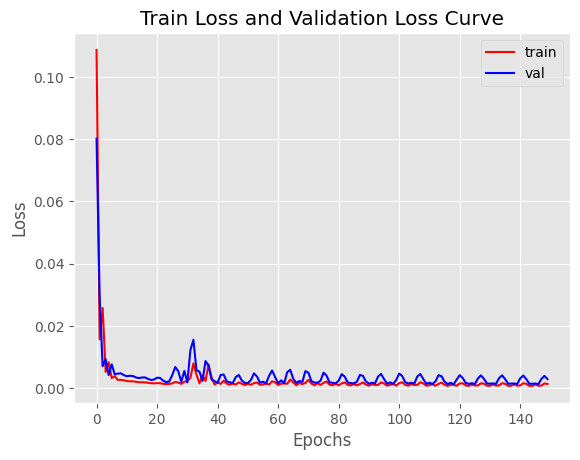

In [13]:
plot_error(train_error,val_error)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
(260, 1)
MSE = 0.0033811916304930328
RMSE = 0.05814801484567666
R-Squared Score = 0.5658504336780197
Accuracy = 0.47307692307692306
Cumulative Strategy = 0.021915926901459493


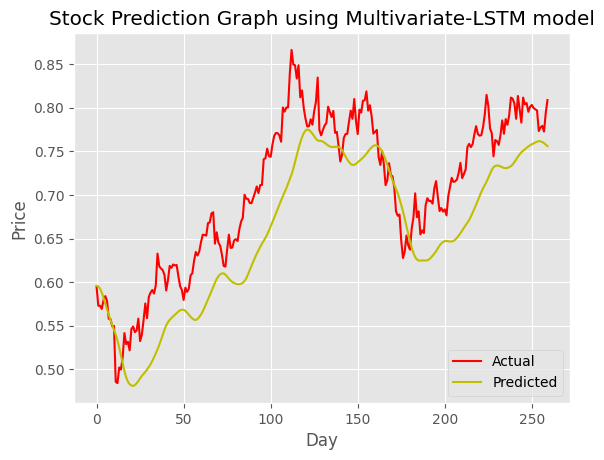

In [14]:
mse, rmse, r2_value,true,predicted, accu, cumu = evaluate_model(model,test,timesteps, sc)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
print('Accuracy = {}'.format(accu))
print('Cumulative Strategy = {}'.format(cumu))
plot_data(true,predicted)

In [15]:
# Evaluating the model
def generate_output(model,all_data,timesteps, sc):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,all_data.shape[0]+1):
        X_test.append(all_data[i-timesteps:i, 0:4])
        Y_test.append(all_data[i-1][4])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    print(Y_hat.shape)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    print(Y_hat.shape)

    Y_hat_tmp= np.zeros_like(all_data)
    Y_hat_tmp[:len(Y_hat),4] = Y_hat.reshape(-1)
    Y_hat_tmp = sc.inverse_transform(Y_hat_tmp)[:,4]

    Y_test_tmp = np.zeros_like(all_data)
    Y_test_tmp[:len(Y_test),4] = Y_test.reshape(-1)
    Y_test_tmp = sc.inverse_transform(Y_test_tmp)[:,4]


    return mse, rmse, r, Y_test_tmp, Y_hat_tmp
  

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
(1950, 1)
(1950, 1)


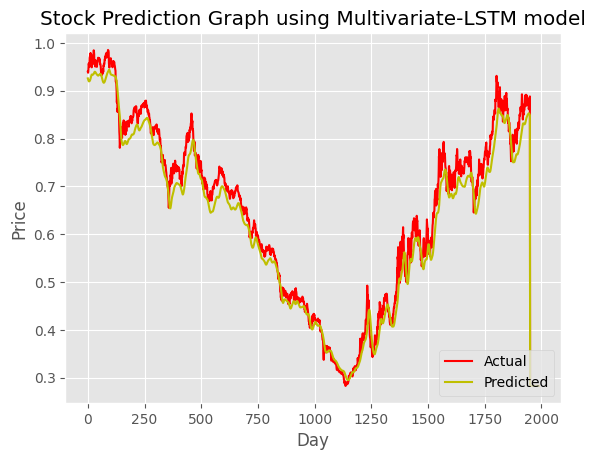

In [16]:
mse, rmse, r2_value,true,predicted = generate_output(model,all_data,timesteps, sc)
plot_data(true,predicted)